# Causal discovery of time series


*Version of this code is running under Windows. Excuted on September 3rd 2019* for
 time series causality analysis. We mostly investigate time-series from dynamical systems.

We use TIGRAMITE (see J.Runge paper and software) which is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on a causal discovery algorithm and create high-quality plots of the results.
This tutorial explains the main features and gives walk-through examples. It covers:

1. Basic usage
2. Plotting
3. Nonlinear conditional independence tests

The other topics are listed below.

## 1. Basic usage

In [6]:
# Imports
import numpy
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction


Consider time series coming from a data generating process

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.7 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``pp.var_process``.

In [7]:
numpy.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object
dataframe = pp.DataFrame(data)

# Specify time axis and variable names
datatime = numpy.arange(len(data))
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']

First, we plot the time series. This can be done with the function ``tp.plot_timeseries``

<class 'numpy.ndarray'>
(1000, 4)


Text(0.5, 0, 'time')

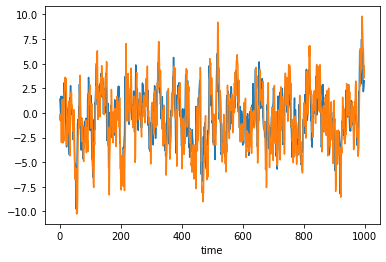

In [8]:
import pandas as pd
from matplotlib import pyplot as plt


'''tp.plot_timeseries(data, datatime, var_names)'''
array = dataframe.values
print(type(dataframe.values))
print(array.shape)

plt.plot(array[:,1])
plt.xlabel('time')

plt.plot(array[:,2])
plt.xlabel('time')


It's stationary and doesn't contain missing values (covered below). 

Next, we choose a conditional independence test, here we start with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. 

In [9]:
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

parcorr = ParCorr(significance='analytic')



Then we initialize the ``PCMCI`` method with  ``dataframe``, ``cond_ind_test``, and (optionally) ``var_names``:

In [11]:
from tigramite.pcmci import PCMCI


pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

'''
for J.R.
I deleted the element     var_names=var_names not to get errors
'''

Before running the causal algorithm, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.

In [12]:
correlations = pcmci.get_lagged_dependencies(tau_max=20)



## Estimating lagged dependencies


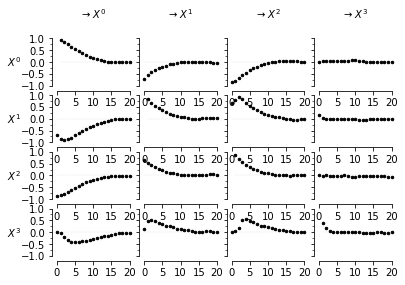

In [13]:
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5})

Since the dependencies decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for the causal algorithm. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``).

In [14]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Running Tigramite PC algorithm
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = None
max_conds_dim = None
max_combinations = 1



## Variable 0

## Variable 1

## Variable 2

## Variable 3

## Resulting condition sets:

    Variable 0 has 7 parent(s):
    [pc_alpha = 0.3]
        (0 -1): max_pval = 0.00000, min_val = 0.796
        (1 -1): max_pval = 0.00000, min_val = 0.748
        (3 -2): max_pval = 0.13715, min_val = 0.048
        (3 -1): max_pval = 0.19326, min_val = 0.042
        (2 -1): max_pval = 0.20477, min_val = 0.041
        (3 -7): max_pval = 0.25822, min_val = 0.036
        (1 -4): max_pval = 0.26548, min_val = 0.036

    Variable 1 has 4 parent(s):
    [pc_alpha = 0.3]
        (1 -1): max_pval = 0.00000, min_val = 0.695
        (3 -1): max_pval = 0.00000, min_val = 0.484
        (3 -7): max_pval = 0.14660, min_val = 0.046
        (2 -1): max_pval = 0.22144, min_val = 0.039

    Variable 2 has 4 parent(s):
    [pc_alpha = 0.2]
        (

As you can see from the output, PCMCI selected different ``pc_alpha`` for each variable. The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations), and optionally its confidence bounds (can be specified upon initializing ``ParCorr``). ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry ``(i, j, \tau)`` denoting the test for the link $X^i_{t-\tau} \to X^j_t$. Per default, the MCI values for $\tau=0$ are not evaluated (can be changed with ``tau_min`` argument).

In [15]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.262 0.894 0.886 0.034 0.417 0.255 0.877]
  [0.067 0.296 0.095 0.765 0.502 0.242 0.234 0.899 0.951]
  [0.832 0.657 0.453 0.011 0.359 0.48  0.901 0.243 0.375]
  [0.827 0.656 0.495 0.592 0.643 0.976 0.775 0.931 0.759]]

 [[0.067 0.    0.15  0.51  0.041 0.005 0.559 0.533 0.392]
  [1.    0.    0.911 0.07  0.576 0.556 0.175 0.732 0.741]
  [0.651 0.764 0.    0.231 0.495 0.43  0.423 0.944 0.238]
  [0.153 0.171 0.088 0.989 0.965 0.859 0.915 0.43  0.671]]

 [[0.832 0.1   0.182 0.443 0.37  0.265 0.998 0.89  0.65 ]
  [0.651 0.072 0.594 0.387 0.883 0.765 0.696 0.44  0.69 ]
  [1.    0.    0.074 0.942 0.956 0.626 0.818 0.526 0.942]
  [0.788 0.575 0.332 0.658 0.603 0.65  0.816 0.055 0.851]]

 [[0.827 0.03  0.021 0.597 0.635 0.2   0.392 0.081 0.85 ]
  [0.153 0.    0.558 0.534 0.72  0.284 0.798 0.016 0.162]
  [0.788 0.114 0.781 0.    0.975 0.098 0.265 0.161 0.642]
  [1.    0.    0.937 0.85  0.503 0.657 0.394 0.795 0.567]]]
MCI partial correlations
[[[ 0.    0.57  0.04  0.   -0.

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. At a chosen significance level the detected parents of each variable can then be printed:

In [17]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')


In [ ]:
'''
commented text not to have Attribute error
pcmci._print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
'''

## 2. Plotting

Tigramite currently offers three plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the boolean ``link_matrix`` which denotes significant links by ``1``.

In [26]:

print(q_matrix)



[[[1.00000000e+000 6.18620330e-082 8.27159397e-001 9.91568308e-001
   9.91568308e-001 3.07016431e-001 9.68395228e-001 8.27159397e-001
   9.91568308e-001]
  [6.69922498e-002 8.81277718e-001 5.32196255e-001 9.91568308e-001
   9.68395228e-001 8.27159397e-001 8.27159397e-001 9.91568308e-001
   9.91568308e-001]
  [8.32473492e-001 9.68395228e-001 9.68395228e-001 1.38999190e-001
   9.68395228e-001 9.68395228e-001 9.91568308e-001 8.27159397e-001
   9.68395228e-001]
  [8.27298364e-001 9.68395228e-001 9.68395228e-001 9.68395228e-001
   9.68395228e-001 9.91568308e-001 9.91568308e-001 9.91568308e-001
   9.91568308e-001]]

 [[6.69922498e-002 9.07098120e-118 7.38461600e-001 9.68395228e-001
   3.50422133e-001 7.06126064e-002 9.68395228e-001 9.68395228e-001
   9.68395228e-001]
  [1.00000000e+000 4.55519321e-104 9.91568308e-001 5.00526072e-001
   9.68395228e-001 9.68395228e-001 7.45337745e-001 9.91568308e-001
   9.91568308e-001]
  [6.50604535e-001 9.91568308e-001 1.14559556e-047 8.27159397e-001
   9.68

In [27]:
'''
commented not to have 
AttributeError: 'PCMCI' object has no attribute '_return_significant_parents'


'''
link_matrix = pcmci._return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']


AttributeError: 'PCMCI' object has no attribute '_return_significant_parents'

In [25]:
#print(np.nnz(geom_net_matr))
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline


#uniform_data = np.random.rand(10, 12)
#ax = sns.heatmap(q_matrix)
#plt.show()

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

We should get something like this 

In [1]:
# TODO to correct time plotting functions under Windows

# Plot time series graph
'''
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
   # var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    )

tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    #var_names=var_names,
    link_colorbar_label='MCI',
    )
    '''

"\ntp.plot_graph(\n    val_matrix=results['val_matrix'],\n    link_matrix=link_matrix,\n   # var_names=var_names,\n    link_colorbar_label='cross-MCI',\n    node_colorbar_label='auto-MCI',\n    )\n\ntp.plot_time_series_graph(\n    val_matrix=results['val_matrix'],\n    link_matrix=link_matrix,\n    #var_names=var_names,\n    link_colorbar_label='MCI',\n    )\n    "

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off.

## 3. Nonlinear conditional independence tests

If nonlinear dependencies are present, it is advisable to use a nonparametric test. Consider the following model:

\begin{align*}
    X^0_t &= 0.2 (X^1_{t-1})^2 + \eta^0_t\\
    X^1_t &= \eta^1_t \\
    X^2_t &= 0.3 (X^1_{t-2})^2 + \eta^2_t
\end{align*}

In [29]:
numpy.random.seed(1)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] += 0.4*data[t-1, 1]**2
    data[t, 2] += 0.3*data[t-2, 1]**2
dataframe = pp.DataFrame(data)


In [32]:

#plot time series

#tp.plot_timeseries(data), var_names=var_names)

In [15]:
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    var_names=var_names,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2)

#TODO: correct Attribute error
'''
pcmci_parcorr._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
        
'''        


## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val = 0.234


``ParCorr`` here fails in two ways: (1) It cannot detect the two nonlinear links, (2) it wrongly detects a link $X^0_{t-1} \to X^2_t$ because it also cannot *condition out* a nonlinear dependency.

### GPDC

Tigramite covers nonlinear additive dependencies with a test based on *Gaussian process* regression and a *distance correlation* (``GPDC``) or *maximal correlation* (``GPACE``) on the residuals. Here we demonstrate GPDC since GPACE requires an R-package. For GPDC no analytical null distribution is available. One can either use a computationally expensive shuffle test throughout or the null distribution can be pre-computed for different anticipated sample sizes with ``generate_and_save_nulldists`` and stored to disk (could be run overnight:). Then ``significance='analytic'`` loads this file. If no file is given, the distribution is generated and stored in cache. GP regression is performed with ``sklearn`` default parameters, except for the *kernel* which here defaults to the radial basis function + a white kernel (both hyperparameters are internally optimized) and the assumed noise level ``alpha`` which is set to zero since we added a white kernel. These and other parameters can be set via the ``gp_params`` dictionary. See the documentation in ``sklearn`` for further discussion.

In [35]:
gpdc = GPDC(significance='analytic', gp_params=None)
# gpdc.generate_and_save_nulldists(sample_sizes=range(495, 501),
#     null_dist_filename='dc_nulldists.npz')
gpdc.null_dist_filename ='dc_nulldists.npz'
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
   # var_names=var_names,
    verbosity=0)

In contrast to ParCorr, the nonlinear links are correctly detected with GPDC:

In [ ]:
'''
#TODO: correct problem with Attribute error

results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1)
pcmci_gpdc._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)'''

As a short excursion, we can see how GPDC works looking at the scatter plots:

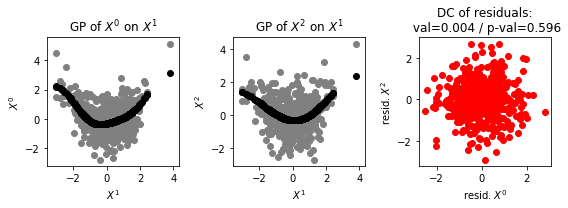

In [18]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red')
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

Let's look at some even more nonlinear dependencies in a model with multiplicative noise:

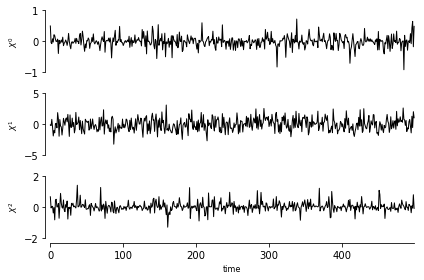

In [19]:
numpy.random.seed(42)
data = numpy.random.randn(500, 3)
for t in range(1, 500):
    data[t, 0] *= 0.2*data[t-1, 1]
    data[t, 2] *= 0.3*data[t-2, 1]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(data, var_names=var_names)

# corrected time-seires plotting using numpy 

Since multiplicative noise violates the assumption of additive dependencies underlying GPDC, the spurious link  $X^0_{t-1} \to X^2_t$ is wrongly detected because it cannot be *conditioned out*. In contrast to ParCorr, however, the two true links *are* detected because DC detects any kind of dependency:

In [20]:
#TODO correct error with Var_names 
# no attribut var_names 

pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    var_names=var_names)

results = pcmci_gpdc.run_pcmci(tau_max=2, pc_alpha=0.1)
pcmci_gpdc._print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($X^1$ -1): pval = 0.00000 | val = 0.034

    Variable $X^1$ has 0 link(s):

    Variable $X^2$ has 2 link(s):
        ($X^1$ -2): pval = 0.00000 | val = 0.025
        ($X^0$ -1): pval = 0.00400 | val = 0.018


Here we can see in the scatter plot, that the Gaussian Process cannot fit the dependencies and the residuals are, thus, not independent.

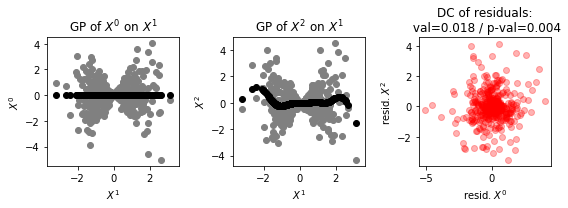

In [21]:
array, dymmy, dummy = gpdc._get_array(X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)
x, meanx = gpdc._get_single_residuals(array, target_var=0, return_means=True)
y, meany = gpdc._get_single_residuals(array, target_var=1, return_means=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
axes[0].scatter(array[2], array[0], color='grey')
axes[0].scatter(array[2], meanx, color='black')
axes[0].set_title("GP of %s on %s" % (var_names[0], var_names[1]) )
axes[0].set_xlabel(var_names[1]); axes[0].set_ylabel(var_names[0])
axes[1].scatter(array[2], array[1], color='grey')
axes[1].scatter(array[2], meany, color='black')
axes[1].set_title("GP of %s on %s" % (var_names[2], var_names[1]) )
axes[1].set_xlabel(var_names[1]); axes[1].set_ylabel(var_names[2])
axes[2].scatter(x, y, color='red', alpha=0.3)
axes[2].set_title("DC of residuals:" "\n val=%.3f / p-val=%.3f" % (gpdc.run_test(
            X=[(0, -1)], Y=[(2, 0)], Z=[(1, -2)], tau_max=2)) )
axes[2].set_xlabel("resid. "+var_names[0]); axes[2].set_ylabel("resid. "+var_names[2])
plt.tight_layout()

### CMIknn

The most general conditional independence test implemented in Tigramite is CMIknn based on conditional mutual information estimated with a k-nearest neighbor estimator. CMIknn involves no assumptions about the dependencies. The parameter ``knn`` determines the size of hypercubes, ie., the (data-adaptive) local length-scale. Now we cannot even pre-compute the null distribution because CMIknn is not residual-based like GPDC and the nulldistribution depends on many more factors. We, therefore, use ``significance='shuffle_test'`` to generate it in each individual test. The following cell may take some minutes.

In [22]:
# cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5)
# pcmci_cmi_knn = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=cmi_knn,
#     var_names=var_names,
#     verbosity=2)
# results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05)
# pcmci_cmi_knn._print_significant_links(
#         p_matrix = results['p_matrix'], 
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)

In [23]:
## Significant links at alpha = 0.01:

#     Variable $X^0$ has 1 link(s):
#         ($X^1$ -1): pval = 0.00000 | val = 0.108

#     Variable $X^1$ has 0 link(s):

#     Variable $X^2$ has 1 link(s):
#         ($X^1$ -2): pval = 0.00000 | val = 0.080

In [24]:
# link_matrix = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
#                         val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
# tp.plot_graph(
#     val_matrix=results['val_matrix'],
#     link_matrix=link_matrix,
#     var_names=var_names,
#     link_colorbar_label='cross-MCI',
#     node_colorbar_label='auto-MCI',
#     )

Here CMIknn correctly detects the true links and also unveils the spurious link. While CMIknn may now seem as the best independence test choice, we have to note that the generality comes at the cost of much lower power for the case that the dependencies actually follow some parametric form. Then ParCorr or GPDC are much more powerful measures. Of course, ParCorr also detects linear links better than GPDC. 

### RCOT

Another option as a fully non-parametric test is based on Kernel measures (https://arxiv.org/abs/1702.03877). We here implement a test wrapped around the r-package ``rcit``, so you need to set that up as described in the documentation of the RCOT class. The test does not require a shuffle test and is, hence, much faster than CMIknn. However, it should only be used for sample sizes larger than 1000 or so, because the analytical approximation of the null distribution may not be valid for smaller sizes. Another drawback vs CMIknn is that it may not work for nonlinearities on very fine scales. The method is very new and numerical comparisons are still missing.

In [25]:
# from tigramite.independence_tests import RCOT
# rcot = RCOT(significance='analytic')
# pcmci_rcot = PCMCI(
#     dataframe=dataframe, 
#     cond_ind_test=rcot,
#     var_names=var_names,
#     verbosity=0)
# results = pcmci_rcot.run_pcmci(tau_max=2, pc_alpha=0.05)
# pcmci_rcot._print_significant_links(
#         p_matrix = results['p_matrix'], 
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)

## TODO 
work in progress: 
    4. Symbolic time series
    5. Causal assumptions
    6. Missing values and masking
    7. Parallization
    8. PCMCI vs Granger causality
    9. Causal effects and mediation
    10. Optimal predictor selection